## Contents of iPython Notebook

Assignment 2 for Advanced Analytics and Machine Learning: Unsupervised Learning of Stock Returns

by Maria Athena B Engesaeth

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
# Setting up the environment
%pylab inline
%matplotlib inline

import pandas as pd

import sklearn
from sklearn import cluster
from sklearn.decomposition import PCA

import scipy
from scipy.stats import moment
from scipy.stats import ttest_ind

# For running regressions and R-type formulas
import statsmodels
import statsmodels.api as sm
# R type regression formulas
import statsmodels.formula.api as smf

import patsy 

/Library/Python/2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [3]:
# Filepaths
stockreturn2 = '/Users/mariaathena/Dropbox (Personal)/00 Imperial College/1601 Machine Learning/Assignment 2/Data (csv)/stockreturn2.csv'

# Load data into dataframe without overriding header and index column of csv
stock_df = pd.DataFrame.from_csv(stockreturn2, header=None, index_col=False)

### Q1: Descriptive Statistics, Skewness, Kurtosis and % log Returns

In [4]:
# Display table of descriptive statistics of the stock dataframe
stock_df.describe().T

count      mean        std       min       25%       50%       75%  \
0  228.0  0.700432   8.639322 -30.36827 -4.604500  1.007143  5.690602   
1  228.0  0.985980  10.593342 -38.55037 -4.796437  1.256301  6.942344   
2  228.0  1.195732  12.103589 -58.86214 -5.041132  1.715627  9.596882   
3  228.0  0.823606  10.297422 -42.58321 -3.527040  0.987606  6.587528   
4  228.0  0.410459   9.582594 -42.28575 -3.476719  0.644807  5.826744   

        max  
0  30.29147  
1  30.29886  
2  29.13605  
3  28.19700  
4  33.02414

In [5]:
# Compute Skewness i.e. 3rd Moment
stock_skewness = stock_df.apply(lambda x: moment(x, moment=3))
stock_skewness

0     -85.040306
1    -421.296550
2   -1512.910299
3    -787.910935
4    -895.794816
dtype: float64

In [6]:
# Compute Kurtosis i.e. 4th Moment
stock_kurtosis = stock_df.apply(lambda x: moment(x, moment=4))
stock_kurtosis

0     23606.425004
1     51902.193000
2    116253.809928
3     60592.462484
4     64200.105225
dtype: float64

In [7]:
# Compute % log Returns

# Firstly we compute the simple returns and store it in a variable
simple_ret = stock_df.pct_change()

# Then we use this to compute the log returns
log_ret = simple_ret.apply(lambda x: np.log(x))

# Display table of descriptive statistics of the log returns of the stock dataframe including min and max
log_ret.describe().T

count      mean       std       min       25%       50%       75%       max
0   62.0  0.281155  1.484382 -3.640349 -0.533926  0.339213  1.453937  2.753408
1   60.0  0.594596  1.759347 -4.302973 -0.327799  0.466436  1.769038  5.631788
2   55.0  0.154151  1.804746 -4.882452 -0.717225  0.344449  1.644494  2.912282
3   54.0       inf       NaN -3.859132 -0.779503  0.337790  1.400983       inf
4   60.0  0.041246  1.721708 -5.576869 -0.742988  0.106840  1.097747  3.530580

### Q2: Statistical Significance of log Returns

From the below regression results we note that all p-values are below 0.05, generally considered the cut-off point for when a variable is statistically insignificant. In other words we fail reject the null hypothesis that mean returns of the stocks are null.

In [8]:
# Design matrices (endog & exog)
y, X = patsy.dmatrices('stock_df[0] ~ stock_df[1] + stock_df[2] + stock_df[3]', data=stock_df, return_type='dataframe')

#y[:3]
#X[:3]

mod = sm.OLS(y, X)    # Describe model
res = mod.fit()       # Fit model
print res.summary()   # Summarize model

                            OLS Regression Results                            
Dep. Variable:            stock_df[0]   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     30.56
Date:                Wed, 30 Mar 2016   Prob (F-statistic):           1.34e-16
Time:                        14:56:17   Log-Likelihood:                -775.55
No. Observations:                 228   AIC:                             1559.
Df Residuals:                     224   BIC:                             1573.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept       0.1661      0.488      0.340      

### Q3: Covariance and Correlation Matrix

In [9]:
# Compute Covariance Matrix
stock_cov = stock_df.cov()
stock_cov

0           1           2           3          4
0  74.637889   42.281185   48.026917   30.103004  21.069532
1  42.281185  112.218893   70.451876   42.423721  26.299668
2  48.026917   70.451876  146.496870   44.594203  29.242793
3  30.103004   42.423721   44.594203  106.036892  67.452895
4  21.069532   26.299668   29.242793   67.452895  91.826100

In [10]:
# Compute Correlation Matrix
stock_corr = stock_df.corr()
stock_corr

0         1         2         3         4
0  1.000000  0.461992  0.459294  0.338378  0.254503
1  0.461992  1.000000  0.549472  0.388908  0.259080
2  0.459294  0.549472  1.000000  0.357796  0.252128
3  0.338378  0.388908  0.357796  1.000000  0.683579
4  0.254503  0.259080  0.252128  0.683579  1.000000

### Q4: Principal Component Analysis

A Summary of the PCA Approach

1. Standardise the data
2. Obtain the Eigenvectors and Eigenvalues from the covariance matrix or correlation matrix, or perform Singular Vector Decomposition
3. Sort eigenvalues in descending order and choose the k eigenvectors that correspond to the k largest eigenvalues where k is the number of dimensions of the new feature subspace (k≤d)
4. Compute projection matrix (W) from selected k eigenvectors.
5. Transform the original dataset X via W to obtain a k-dimensional feature subspace Y

In [11]:
# Step 1 - Standardise the data
from sklearn.preprocessing import StandardScaler
stock_std_df = StandardScaler().fit_transform(stock_df)
#stock_std_df.shape

In [12]:
# Step 2 - Obtain the Eigenvectors and Eigenvalues from the covariance matrix or correlation matrix

# Covariance matrix of standardised data
stock_std_cov = np.cov(stock_std_df.T)

# Eigendecomposition on the covariance matrix
eig_vals, eig_vecs = np.linalg.eig(stock_std_cov)

print eig_vecs
print "eigenvalues: ", eig_vals

[[-0.42763297 -0.34111318  0.83707913  0.00820318  0.0017559 ]
 [-0.45989335 -0.35645829 -0.38014075  0.14462186 -0.70428199]
 [-0.4511153  -0.38546354 -0.38922685  0.02177744  0.70423082]
 [-0.47856705  0.46946714 -0.04582365 -0.73875733 -0.05207668]
 [-0.41604893  0.62257349  0.0345571   0.6578606   0.07301211]]
eigenvalues:  [ 2.61913608  1.07630477  0.57112107  0.30216155  0.45330297]


In [13]:
# Note: particularly in finance: the correlation matrix is typically used instead of the covariance matrix.
# However, the eigendecomposition of the covariance matrix yields the same results as a eigendecomposition 
# on the correlation matrix, since the correlation matrix can be understood as the normalized covariance matrix.

stock_std_corr = np.corrcoef(stock_std_df.T)
# Eigendecomposition on the correlation matrix
eig_vals, eig_vecs = np.linalg.eig(stock_std_corr)

print eig_vecs
print "eigenvalues: ", eig_vals

[[ 0.42763297  0.34111318 -0.83707913  0.00820318  0.0017559 ]
 [ 0.45989335  0.35645829  0.38014075  0.14462186 -0.70428199]
 [ 0.4511153   0.38546354  0.38922685  0.02177744  0.70423082]
 [ 0.47856705 -0.46946714  0.04582365 -0.73875733 -0.05207668]
 [ 0.41604893 -0.62257349 -0.0345571   0.6578606   0.07301211]]
eigenvalues:  [ 2.60764864  1.07158414  0.56861615  0.30083628  0.4513148 ]


In [14]:
# Step 3 - Sorting Eigenvector, Eigenvalue pairs
# We look for which eigenvector(s) to drop without losing too much information: The eigenvectors with 
# the lowest eigenvalues bear the least information about the distribution of the data.

# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort()
eig_pairs.reverse()

for i in eig_pairs:
    print(i[0])

2.60764864283
1.07158413686
0.568616149904
0.451314795061
0.300836275345


In [28]:
# Compute explained variance to find how much information (variance) can be attributed to each of 
# the principal components in our new feature subspace.
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
var_exp = np.array(var_exp)
cum_var_exp = np.cumsum(var_exp)
print var_exp

[ 52.15297286  21.43168274  11.372323     9.0262959    6.01672551]


In [30]:
# Step 4 - Projection Matrix
# The projection matrix is used to transform the dataset to the new feature subspace
matrix_w = np.hstack((eig_pairs[0][1].reshape(5,1),
                      eig_pairs[1][1].reshape(5,1)))

print matrix_w

[[ 0.42763297  0.34111318]
 [ 0.45989335  0.35645829]
 [ 0.4511153   0.38546354]
 [ 0.47856705 -0.46946714]
 [ 0.41604893 -0.62257349]]


In [31]:
# Step 5 - Project the dataset onto the new feature subspace
Y = stock_std_cov.dot(matrix_w)
Y

array([[ 1.12002894,  0.36714174],
       [ 1.20452326,  0.38365776],
       [ 1.18153237,  0.41487625],
       [ 1.25343223, -0.50528972],
       [ 1.08968876, -0.67007882]])

### Q5: Interpretation and Analysis
##### incl. Bonus Question

To answer the question of how many components explain the data it can be helpful to look at a visualisation of the cumulative variance of each added principal component. As seen in the below plot, the first three (3) prinicpal components explain over 80% of the variation in the data and it may be reasonable to conclude that these three principal components would suffice in explaining the data.

To answer the same questions qualitatively, that is, given the nature of our data we might want to remind ourselves that this is financial data. Each component relates to a stock, companies within the same industry (or perfectly complimentary industries) tend to experience the similar variance. It seems reaonable to assume that a minimum of two (2), and possibly more, of these stocks are from companies in the same industry.

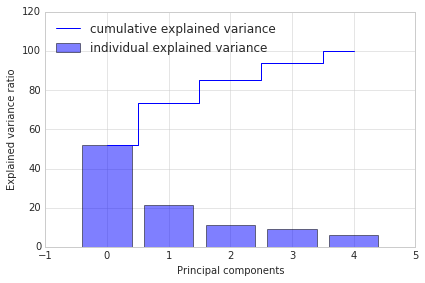

In [27]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(5), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(5), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()